# parPE example: steadystate model - model simulation, optimization, analysis

This notebooks demonstrates basic use of parPE for parameter estimation.

## Prerequisites

This notebook requires:

* a successful *parPE* with CMake options `BUILD_EXAMPLES=ON` (default).
* an installation of the *parPE* Python package (`${PARPE_SOURCE_DIR}/python/`)
  in the Python environment in which this notebook is run (ideally the `build/venv/` virtual environment)

This notebook assumes that this file is used from its default location and that *parPE* was built inside `${PARPE_SOURCE_DIR}/build/`. If this is not the case, adapt `parpe_source_root` and `parpe_build_root` in the following block correspondingly.

In [26]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from importlib import reload
import parpe
from pprint import pprint

# set paths
parpe_source_root = os.path.abspath('../../../')
parpe_build_root = os.path.join(parpe_source_root, 'build')

model_source_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/steadystate_scaled-prefix/src/steadystate_scaled/model_steadystate_scaled'
example_binary_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/'
example_data_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/steadystate_scaled-prefix/src/steadystate_scaled'
optimization_options_py = f'{parpe_source_root}/misc/optimizationOptions.py'

# MPI launcher and options
mpiexec = "mpiexec -n 4 --allow-run-as-root --oversubscribe"

In [27]:
# rebuild example
!cd {parpe_build_root} && make

-- Found Git: /usr/bin/git (found version "2.25.1") 
-- Building version parPE-v0.4.3-37-g5bf1-dirty
[  0%] Built target get_version
[ 10%] Built target parpecommon
[ 21%] Built target parpeoptimization
[ 25%] Built target parpeloadbalancer
[ 37%] Built target parpeamici
[ 39%] Built target parpe
[ 45%] Built target unittests_common
[ 50%] Built target unittests_loadbalancer
[ 58%] Built target unittests_optimization
Setting up virtual environment...
[ 58%] Built target setup_venv
[ 59%] Creating test data using hierarchicalOptimizationTest.py
...
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK
[ 59%] Built target prepare_test_hierarchical_optimization
[ 67%] Built target unittests_amici
[ 69%] Built target example_loadbalancer
[ 81%] Built target steadystate_scaled
[ 84%] Built target example_steadystate
[ 88%] Built target example_steadystate_multi
[ 92%] Built target example_steadystate_multi_simulator
[100%] Built target test_steadys

In [28]:
# run make test to generated all output files required below
!cd {parpe_build_root} && make test

Running tests...
Test project /home/dweindl/src/parPE_2/build
      Start  1: testingMisc.testTenToMinusInf
 1/80 Test  #1: testingMisc.testTenToMinusInf ..................................................   Passed    0.00 sec
      Start  2: testingMisc.testWithinTolerance
 2/80 Test  #2: testingMisc.testWithinTolerance ................................................   Passed    0.00 sec
      Start  3: testingMisc.testCheckEqualArray
 3/80 Test  #3: testingMisc.testCheckEqualArray ................................................   Passed    0.00 sec
      Start  4: testingMisc.testRandInt
 4/80 Test  #4: testingMisc.testRandInt ........................................................   Passed    0.01 sec
      Start  5: commonMisc.testBacktrace
 5/80 Test  #5: commonMisc.testBacktrace .......................................................   Passed    0.00 sec
      Start  6: commonMisc.testFilexists
 6/80 Test  #6: commonMisc.testFilexists ...........................................

## Model and data

This parameter estimation is specified as set of [PEtab](https://github.com/PEtab-dev/PEtab) files which are generated automatically during the build process (see `${PARPE_SOURCE_ROOT}/examples/parpeamici/steadystate`). They consist of an SBML model and set of tabular files describing model parameters, model inputs and measurements (training data). The model is automatically converted to C++ code and compiled and linked with parPE during the CMake-based build. The data has been converted to a HDF5 parPE input file.

The model is loosely based on an [AMICI](https://github.com/AMICI-dev/AMICI/) example. It describes the dynamics of three species. The model has six outputs with respective measurements. The measurements are based on model simulations to which artificial noise has been added. Data was simulated to represent four different experimental conditions, each with different model inputs. Some outputs represent model states directly, others are offsetted or scaled. For all outputs additive normally distributed noise is assumed, the standard deviation is known for some measurements and is to be estimated for others.

Here we use `libsbml` to show the reactions and species described by the model:

In [29]:
import libsbml
sbml_file = f'{example_data_dir}/model_steadystate_scaled.sbml'
sbml_reader = libsbml.SBMLReader()
sbml_doc = sbml_reader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()
dir(sbml_doc)

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(),
                        reactants,
                        reversible,
                         products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))

Species:  ['x1', 'x2', 'x3']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k0 * x3]
 r6:             ->        x1		[p5]


### Test simulation

Performing an exemplary model simulation and plotting state and output trajectories:

In [30]:
# load model
model_module = amici.import_model_module("model_steadystate_scaled", model_source_dir)

model = model_module.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20)))
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())

# Default model parameters: print(default_parameters)
# Result fields reported by AMICI: list(rdata.keys())

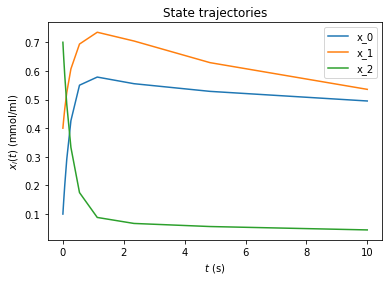

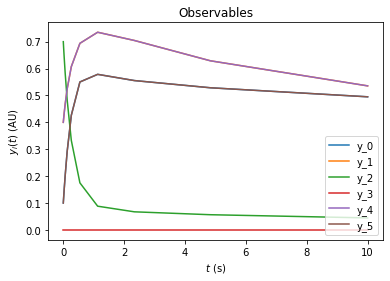

In [31]:
from amici.plotting import plotStateTrajectories
from amici.plotting import plotObservableTrajectories

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)

## Standard optimization Ipopt

In this section, model parameters are estimated. parPE supports different optimization algorithms, available algorithms depend on the build configuration. In this section we will use Ipopt, which worked the best in our experience (https://academic.oup.com/bioinformatics/article/36/2/594/5538985).

Based on the parPE template files, a executable for parameter estimation has been built. By default, these executables are named `estimate_${MODEL_NAME}`. These files require a HDF5 file containing training data and optimization options. All those files have been generated automatically for this example.

This part of the example requires a parPE build with `PARPE_ENABLE_IPOPT=ON`.

### Set parameter estimation options

Parameter estimation settings specified inside an HDF5 file. Those can be changed from any programming language with HDF5 bindings, with hdfview (https://www.hdfgroup.org/downloads/hdfview/), or with a helper script included in parPE, as demonstrated here:

In [32]:
# enable derivative checker
input_file = f'{example_data_dir}/example_data.h5'

#!{optimization_options_py} {input_file} -s ipopt/derivative_test first-order
#!{optimization_options_py} {input_file} -s ipopt/derivative_test_print_all yes

# Use Ipopt
!{optimization_options_py} {input_file} -s optimizer 0

# Perform one optimizer runs from different starting points
!{optimization_options_py} {input_file} -s numStarts 1

# Run for 20 iterations
!{optimization_options_py} {input_file} -s ipopt/max_iter 30

# Disable hierarchical optimization (see below)
!{optimization_options_py} {input_file} -s hierarchicalOptimization 0

# Print settings
!{optimization_options_py} {input_file}

                hierarchicalOptimization            0
                               numStarts            1
                               optimizer            0
                       retryOptimization            1
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-12
                    ipopt/acceptable_tol        1e+20
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter           30
                  

### Gradient check

Before starting the optimization, we can shortly compare the objective function gradients computed by AMICI/parPE with finite differences:

In [33]:
# use three random starting points:
for i in range(3):
    !PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -t gradient_check -o deletemegc/ {input_file}
    print()


[2020-06-24 17:41:30] [INF] [-1:140407870474176/]     0 g: -3.07804e+14  fd_c: -3.07834e+14  Δ/ff: 1.820688e-04  f:  1.61202e+14
[2020-06-24 17:41:30] [INF] [-1:140407870474176/]     1 g: -2.22547e+13  fd_c: -2.23559e+13  Δ/ff: 6.276508e-04  f:  1.61205e+14
[2020-06-24 17:41:30] [INF] [-1:140407870474176/]     2 g:  2.23191e+13  fd_c:  2.23727e+13  Δ/ff: -3.327962e-04  f:  1.61205e+14
[2020-06-24 17:41:30] [INF] [-1:140407870474176/]     3 g:  1.44004e+13  fd_c:  1.43986e+13  Δ/ff: 1.096761e-05  f:  1.61205e+14
[2020-06-24 17:41:30] [INF] [-1:140407870474176/]     4 g:  3.92648e+14  fd_c:  3.92711e+14  Δ/ff: -3.915439e-04  f:  1.61209e+14
[2020-06-24 17:41:30] [INF] [-1:140407870474176/]     5 g:  7.22972e+14  fd_c:  7.22972e+14  Δ/ff: -1.633158e-09  f:  1.61212e+14
[2020-06-24 17:41:30] [INF] [-1:140407870474176/]     6 g:  1.48764e+07  fd_c:  1.48766e+07  Δ/ff: -8.200509e-13  f:  1.61205e+14
[2020-06-24 17:41:30] [INF] [-1:140407870474176/]     7 g: -4.32827e+10  fd_c: -4.32827e+10  

### Optimize

Now we can run the actual optimization.

In [34]:
# !(cd {parpe_build_root} && exec make -j12) # rebuild
!rm -rf deleteme # delete old result files

# optimize (using a single process)
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -o deleteme/ {example_data_dir}/example_data.h5


[2020-06-24 17:41:33] [INF] [-1:140425994618816/] Reading random initial theta 0 from /optimizationOptions/randomStarts

List of user-set options:

                                    Name   Value                used
                         acceptable_iter = 1                     yes
               acceptable_obj_change_tol = 1e-12                 yes
                          acceptable_tol = 1e+20                 yes
                   hessian_approximation = limited-memory        yes
              limited_memory_update_type = bfgs                  yes
                                max_iter = 30                    yes
                             print_level = 5                     yes
                      print_user_options = yes                   yes
                                     tol = 1e-09                 yes
         watchdog_shortened_iter_trigger = 0                     yes

******************************************************************************
This program 

### Analyze results

A good start for checking the results is a look at optimizer trajectories. This can be easily done using the *parPE* Python package:

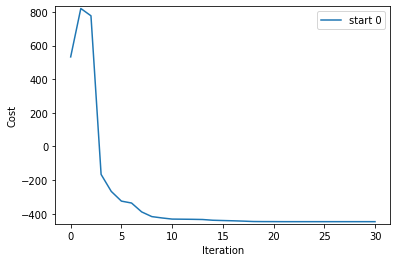

In [35]:
filename = 'deleteme/_rank00000.h5'
trajectories_ipopt = parpe.getCostTrajectories(filename)
#print(repr(trajectories))
parpe.plotting.plotCostTrajectory(trajectories_ipopt, log=False);

Since this example uses artificial data based on model simulations with known parameters, we can compare them to the optimization results:

In [36]:
parpe.compare_optimization_results_to_true_parameters('deleteme/_rank00000.h5')

#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     0.30485    -0.69515    -0.69515 p1
1:   0.50000     0.31305    -0.18695    -0.37391 p2
2:   0.40000     0.16030    -0.23970    -0.59925 p3
3:   2.00000     1.81174    -0.18826    -0.09413 p4
4:   0.10000     0.05128    -0.04872    -0.48718 p5
5:   2.00000     0.16231    -1.83769    -0.91885 scaling_x1_common
6:   3.00000     2.99955    -0.00045    -0.00015 offset_x2_batch_0
7:   0.20000     0.13729    -0.06271    -0.31357 x1withsigma_sigma
8:   4.00000     4.00132     0.00132     0.00033 offset_x2_batch_1

Status: 1
Cost: -447.231981 (expected: -0.000000)


The parameters don't match that greatly. This is not completely unexpected due to the artificial noise introduced. To get a closer look at the optimization result, we can compare the training data to the model output with the optimized parameters.

The model outputs are by default not saved during optimization, because this can lead to much I/O overhead and large files. However, there is an executable to quickly rerun simulation with the optimal parameters:

In [37]:
# Simulate with optimal parameters, save results
!rm -f sim.h5 # remove files from previous run
!{example_binary_dir}/example_steadystate_multi_simulator deleteme/_rank00000.h5 /inputData deleteme/_rank00000.h5 /inputData sim.h5 / --at-optimum --nompi --nocompute-inner

Running --at-optimum for 
	conditions from deleteme/_rank00000.h5:/inputData and 
	parameters from deleteme/_rank00000.h5:/inputData
	> sim.h5:/
Running for start 0
Starting simulation. Number of conditions: 4


In [38]:
# Load simulated outputs
(measured, simulated, timepoints, llh) = parpe.readSimulationsFromFile('sim.h5')
start_idx = '0'

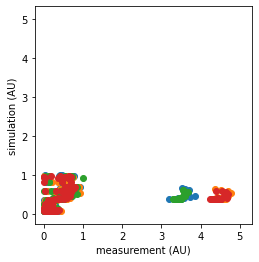

In [39]:
# Plot correlation of measurements (training data) and model simulation with optimized parameters
parpe.plotting.plotCorrelation(measured[start_idx], simulated[start_idx])

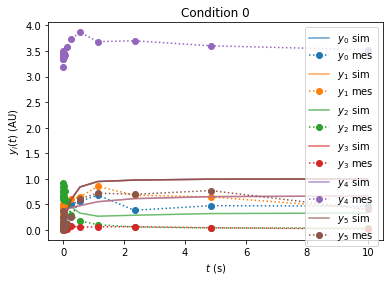

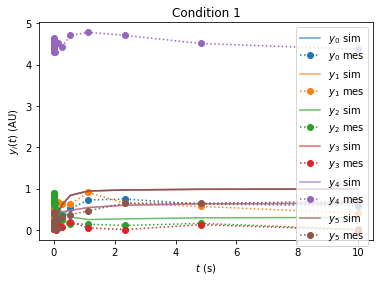

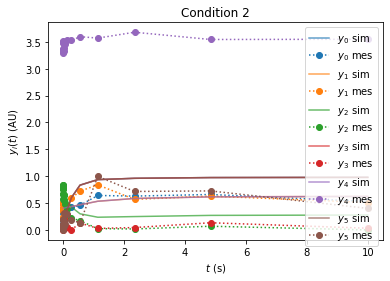

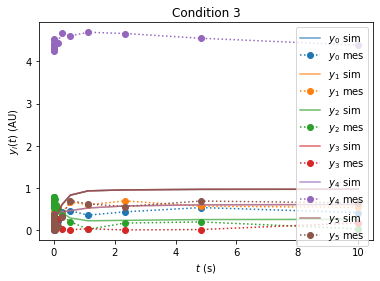

In [40]:
# Plot measurement trajectories (training data) and compare to model simulation with optimized parameters
parpe.plotting.plotTrajectoryFits(measured[start_idx], simulated[start_idx], timepoints[start_idx])

## Changing optimizers - Ceres

Once parPE has been built with support for different optimizers, selecting a different optimizer is quite easy.

This part of the example requires a parPE build with `PARPE_ENABLE_CERES=ON`. We can check the available optimizers like this:

In [ ]:
!{example_binary_dir}/example_steadystate_multi -h

In [ ]:
import subprocess
import re

result = subprocess.run(
    [f'{example_binary_dir}/example_steadystate_multi', '-h'],
    capture_output=True,
    text=True
)
ceres_enabled = False
if result.returncode == 0:
    ceres_enabled = re.search(r'OPTIMIZER_CERES.*enabled', result.stdout) is not None

In [41]:
if ceres_enabled:
    # copy input file from above example
    example_data_ceres = f'{example_data_dir}/example_data_ceres.h5'
    !cp {example_data_dir}/example_data.h5 {example_data_ceres}

    # Change optimizer to CERES
    # NOTE: For this moment, optimizers are inconveniently selected based on numeric values, 0 is Ipopt, 1 is Ceres.
    !{optimization_options_py} {example_data_ceres} -s optimizer 1

    # Run optimization
    !PARPE_NO_DEBUG=1 {mpiexec} {example_binary_dir}/example_steadystate_multi  -o deletemeceres/ {example_data_ceres} --mpi
else:
    print('Ceres optimizer not enabled in this build')

[2020-06-24 17:41:41] [INF] [0:139880673687488/dweindl-ThinkPad-L480] Running with 4 MPI processes.
[2020-06-24 17:41:41] [INF] [0:139880673687488/dweindl-ThinkPad-L480] Reading random initial theta 0 from /optimizationOptions/randomStarts
callbacks.cc:105    0: f: 5.323027e+02 d: 0.00e+00 g: 4.46e+03 h: 0.00e+00 s: 0.00e+00 e:  0 it: 4.13e-02 tt: 4.13e-02
[2020-06-24 17:41:41] [INF] [0:139880252290816/dweindl-ThinkPad-L480] [o0i0] iter: 0 cost: 532.303 time_iter: wall: 0.0415566s cpu: 0.0809107s time_optim: wall: 0.0415569s cpu: 0.0809107s
callbacks.cc:105    1: f:-3.344605e+02 d: 8.67e+02 g: 1.67e+02 h: 1.13e+00 s: 2.24e-04 e:  1 it: 3.72e-02 tt: 7.95e-02
[2020-06-24 17:41:41] [INF] [0:139880252290816/dweindl-ThinkPad-L480] [o0i1] iter: 1 cost: -334.461 time_iter: wall: 0.0382083s cpu: 0.0764133s time_optim: wall: 0.0797655s cpu: 0.157324s
callbacks.cc:105    2: f:-3.788412e+02 d: 4.44e+01 g: 3.85e+02 h: 3.29e-01 s: 1.28e-03 e:  5 it: 1.56e-01 tt: 2.36e-01
[2020-06-24 17:41:41] [INF]

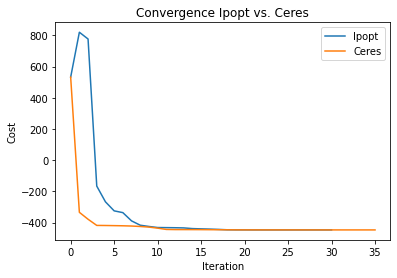

In [42]:
if ceres_enabled:
    ceres_optimization_result_filename = 'deletemeceres/_rank00000.h5'
    trajectories_ceres = parpe.getCostTrajectories(ceres_optimization_result_filename)
    #print(repr(trajectories))
    ax = parpe.plotting.plotCostTrajectory(trajectories_ipopt, log=False);
    parpe.plotting.plotCostTrajectory(trajectories_ceres, log=False, ax=ax);
    ax.autoscale(True)
    ax.legend(['Ipopt', 'Ceres'])
    ax.set_title('Convergence Ipopt vs. Ceres');

In [43]:
if ceres_enabled:
    parpe.compare_optimization_results_to_true_parameters(ceres_optimization_result_filename)

#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     0.30548    -0.69452    -0.69452 p1
1:   0.50000     0.30052    -0.19948    -0.39895 p2
2:   0.40000     0.16337    -0.23663    -0.59158 p3
3:   2.00000     1.81043    -0.18957    -0.09478 p4
4:   0.10000     0.04597    -0.05403    -0.54034 p5
5:   2.00000     0.16233    -1.83767    -0.91883 scaling_x1_common
6:   3.00000     2.99965    -0.00035    -0.00012 offset_x2_batch_0
7:   0.20000     0.13703    -0.06297    -0.31484 x1withsigma_sigma
8:   4.00000     4.00120     0.00120     0.00030 offset_x2_batch_1

Status: 0
Cost: -447.236062 (expected: -0.000000)


## Changing simulator settings

ParPE uses AMICI for model simulation. The respective settings are stored in the HDF5 input file in the `/amiciOptions` group:

In [ ]:
# let's create a copy of the previous input file
input_file_fsa = f'{example_data_dir}/example_data_fsa.h5'
!cp {input_file} {input_file_fsa}

# first, we just look at the current settings
with h5py.File(input_file_fsa, 'r') as f:
    pprint(dict(f['/amiciOptions'].attrs))


There is currently no detailed documentation of the attributes available, but they can be looked up in `amici::writeSolverSettingsToHDF5` in `deps/AMICI/src/hdf5.cpp`. There are additional settings available to the ones shown above.
The relevant attributes for sensitivity analysis are `sensi_meth` (and `sensi_meth_preeq`, if preequilibration is used). This is how you can change them:

In [ ]:
with h5py.File(input_file_fsa, 'r+') as f:
    print(f'Before: sensi_meth={amici.SensitivityMethod(f["/amiciOptions"].attrs["sensi_meth"])!r}')
    print(f'Before: sensi_meth_preeq={amici.SensitivityMethod(f["/amiciOptions"].attrs["sensi_meth_preeq"])!r}')
    f["/amiciOptions"].attrs["sensi_meth"] = amici.SensitivityMethod.forward
    f["/amiciOptions"].attrs["sensi_meth_preeq"] = amici.SensitivityMethod.forward
    print(f'After: sensi_meth={amici.SensitivityMethod(f["/amiciOptions"].attrs["sensi_meth"])!r}')
    print(f'After: sensi_meth_preeq={amici.SensitivityMethod(f["/amiciOptions"].attrs["sensi_meth_preeq"])!r}')


Other settings can be changed in the same way. The important ones will probably be the integration tolerances and the maximum number of integration steps.

### FSA vs. ASA

We can repeat the optimization with the updated input file and compare the results from forward sensitivity analysis to adjoint sensitivity analysis:

In [ ]:
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -o deleteme-fsa/ {input_file_fsa}


In [ ]:
filename = 'deleteme-fsa/_rank00000.h5'
trajectories_ipopt_asa = trajectories_ipopt.copy()
trajectories_ipopt_fsa = parpe.getCostTrajectories(filename)
ax = parpe.plotting.plotCostTrajectory(trajectories_ipopt_asa, log=False)
parpe.plotting.plotCostTrajectory(trajectories_ipopt_fsa, log=False, ax=ax);

In [ ]:
# pad trajectories to the same length
tmp = np.full((np.fmax(len(trajectories_ipopt_asa), len(trajectories_ipopt_fsa)), 2), np.nan)
tmp[:len(trajectories_ipopt_asa), 0] = trajectories_ipopt_asa.squeeze()
tmp[:len(trajectories_ipopt_fsa), 1] = trajectories_ipopt_fsa.squeeze()

# create dataframe
df = pd.DataFrame(tmp, columns=['fval Ipopt ASA', 'fval Ipopt FSA'])
df["diff"] = df['fval Ipopt ASA'] - df['fval Ipopt FSA']
df

As expected, the differences are tiny.